Importamos funciones

In [214]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from ipynb.fs.full.Funciones_basicas import *
from ipynb.fs.full.Algoritmos import *
from ipynb.fs.full.Visualizaciones import *

In [215]:
from collections import deque
import random

Leemos grafo

In [216]:
path_geom = '../data/graph_geom_corrected_cycles.csv'
geometry = gpd.read_file(path_geom, GEOM_POSSIBLE_NAMES="geometry", KEEP_GEOM_COLUMNS="NO")
     
path = '../data/corrected_dijkstra.csv'
csv_grafo = pd.read_csv(path, sep=',')

path_pesos = '../data/pesos_tapas.csv'
pesos = pd.read_csv(path_pesos)

out = {1003950, 15004, 15131, 1003744, 15190, 1003746, 13730, 1003167, 13731, 13732, 13733, 14062, 1003206, 16503, 13735, 16094, 16095}

S = set()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        S.add(origin)
        S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

Tree = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        Tree.add_edge(id_[origin], id_[dest])
        
G = nx.DiGraph()
for index, row in csv_grafo.iterrows():
    origin = row['self']
    dest = row['other']
    if origin not in out and dest not in out:
        G.add_edge(id_[origin], id_[dest])
    
N = l

W = [0] * N

for u in range(N):
    if pesos[pesos['ID_tapa'] == _id[u]].shape[0] >= 1:  ## tomamos primera columna con el id, si no hay peso = 0
        W[u] = pesos[pesos['ID_tapa'] == _id[u]].iloc[0]['per_predio']

Obtenemos carácterísticas del grafo

## Algoritmo
Parámetros iniciales

In [52]:
J = N
J = 30 # N
O = deque([0], int(1e6)) #0 es WTF
S = 0
#F_l = #largo de calles
#P_n = # cantidad de salidas desde el nodo
G = nx.DiGraph()
l = 0

Main loop

In [103]:
while True:
    # Parámetros
    J = N
    J = 40 # N
    O = deque([0], int(1e4)) #0 es WTF
    S = 0
    F_l = list(range(1,6)) # Largo de las calles
    P_n = [1, 1, 1, 1, 2, 2, 3, 3, 4] # cantidad de salidas desde el nodo
    G = nx.DiGraph()
    l = 0
    
    # Main loop
    while O: 
        # nts: next_tree_segment
        nts = O.popleft()
        growth = random.choice(P_n) 
        lenght_ = random.sample(F_l, growth)
        
        for i in range(1, growth + 1):
            G.add_edge(l + i, nts, length = lenght_[i - 1])
            O.append(l+i)
            
        l += growth
        S += growth
        
        
        if S >= J:
            break
    
    if len(G.nodes()) > J:
        break

In [104]:
len(G.nodes())

41

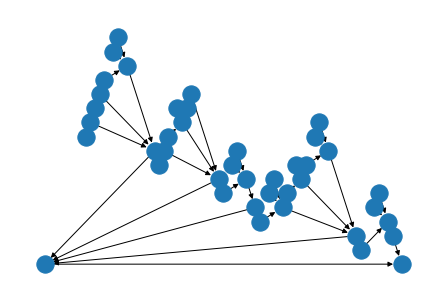

In [105]:
layout = nx.planar_layout(G)
nx.draw(G, pos = layout, with_labels = False )

In [99]:
max_depth = 15
T = Tree.subgraph([node for node in list(Tree.nodes()) if nx.shortest_path_length(Tree, source = node, target = 744) <= max_depth])
print(len(T.nodes()))

42


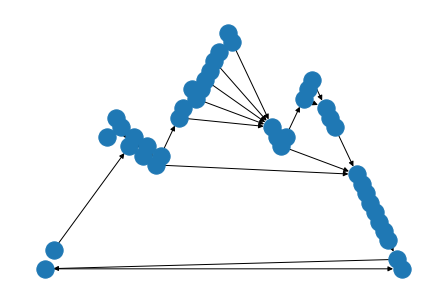

In [101]:
layout = nx.planar_layout(T)
nx.draw(T, pos = layout, with_labels = False )

## California data

Leemos grafo desde base de datos

In [271]:
path_nodes = '../data_random/TG.txt'
nodes_location = pd.read_csv(path_nodes, sep=" ", header=None, names = ['ID', 'Longitude', 'Latitude'])
path_edges = '../data_random/TG_edge.txt'
edges_location = pd.read_csv(path_edges, sep=" ", header=None, names = ['edge_ID', 'ID_1', 'ID_2', 'Distance'])
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


### Agregar tapas capa D distancia

In [272]:
S = set()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    S.add(origin)
    S.add(dest)

S = list(S)
id_ = {}; _id = {}; l = 0
for u in S:
    id_[u] = l; _id[l] = u
    l += 1

        
G = nx.Graph()
for index, row in edges_location.iterrows():
    origin = row['ID_1']
    dest = row['ID_2']
    G.add_edge(id_[origin], id_[dest])
    
N = l

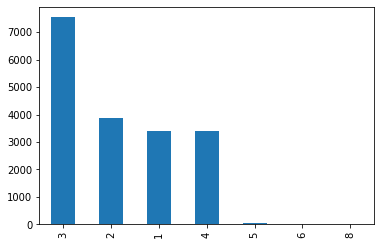

In [273]:
freq = [len(list(G.neighbors(i) )) for i in range(len(G.nodes()))]
pd.Series(freq).value_counts().plot(kind='bar')

In [274]:
def by_distance(element):
    return element[1]


def get_closest(G, locations, node, q):
    # get position of node
    x = locations[locations['ID'] == _id[node]]['Longitude'].iloc[0]
    y = locations[locations['ID'] == _id[node]]['Latitude'].iloc[0]
    
    #Neighbors
    ng = list(G.neighbors(node))
    
    # Calculate distances
    distances = list()
    for n in ng:
        n_id = _id[n]
        x_row = locations[locations['ID'] == n_id]['Longitude'].iloc[0]
        y_row = locations[locations['ID'] == n_id]['Latitude'].iloc[0]
        d = (x - x_row)**2 + (y - y_row)**2
        distances.append((n, d))
    
    # Order by distance and return q closest
    distances.sort(key = by_distance)    
    return [i[0] for i in distances[:q]] 

In [298]:
def get_random_tree(G, nodes):
    new_G = nx.DiGraph()
    N = len(G.nodes())
    WTP = random.choice(list(G.nodes()))
    V = [0] * N;  V[WTP] = 1
    Q = deque([]); Q.append(WTP)
    while Q:
        if len(new_G.nodes()) < nodes:
            random.shuffle(Q)
            u = Q.popleft()
            for v in G.neighbors(u):
                if not V[v]:
                    Q.append(v)
                    new_G.add_edge(v,u)
                    V[v] = 1
        else:
            break
    return new_G

def add_extra_edges(T, G, locations, ratio, edge_limit):
    nodes = list(T.nodes())
    counter = 0
    perturbed = random.choices(nodes, k = math.ceil(len(nodes) * ratio))
    for node in perturbed:
        added = False
        if len(list(T.predecessors(node))) < edge_limit:
            closest = [i for i in get_closest(G, locations, node, 7) if i in nodes]
            if closest:
                closest = closest[0]
                T_neigbors = list(T.predecessors(node)) + list(T.successors(node))
                if len(list(T.predecessors(closest))) < edge_limit and  closest not in T_neigbors:
                    T.add_edge(node, closest)
                    added = True
                    #print('added')
        if not added and counter < len(nodes):
            perturbed.append(random.choice(nodes))
            counter += 1
    return T


In [276]:
def generate_random_graph(G, nodes, locations, ratio, edge_limit):
    T = get_random_tree(G, nodes)
    NG = add_extra_edges(T,G, locations, ratio, edge_limit)
    return NG
        

added
added


11

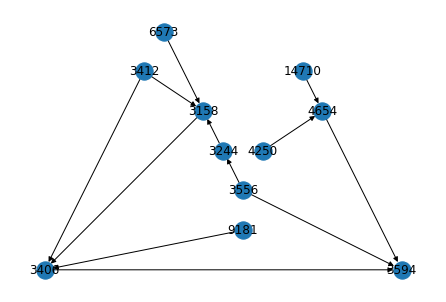

In [280]:
#U = nx.complete_graph(8)
R = get_random_tree(G, 10)
R = add_extra_edges(R,G, nodes_location, 0.4, 5)
layout = nx.planar_layout(R)
nx.draw(R, pos = layout, with_labels = True)
len(R.nodes())

added


10

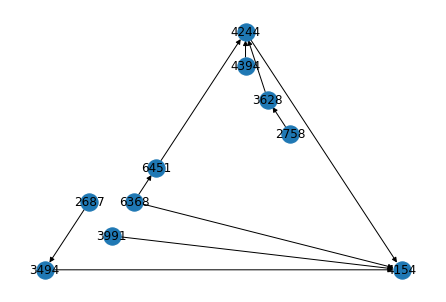

In [287]:
G_ = generate_random_graph(G, 10, nodes_location, 0.5, 4)
layout = nx.planar_layout(G_)
nx.draw(G_, pos = layout, with_labels = True)
len(G_.nodes())

## Visualización de resultados

In [289]:
from shapely.geometry import LineString, Point

In [290]:
geometry.head()
edges_location.head()

,edge_ID,ID_1,ID_2,Distance
0,0,0,7388,1.410871
1,1,0,5744,1.069441
2,2,0,5835,34.071991
3,3,0,3647,14.796446
4,4,1,4232,136.073166


Primero obtenemos localizaciones de cada nodo y los asociamos a sus respectivas aristas

In [291]:
def get_location_node(locations, node):
    x = locations[locations['ID'] == node]['Longitude'].iloc[0]
    y = locations[locations['ID'] == node]['Latitude'].iloc[0]
    return x,y

def create_linestring(row, locations):
    node_1 = row['ID_1']
    node_2 = row['ID_2']
    x_1, y_1 = get_location_node(locations, node_1)
    x_2, y_2 = get_location_node(locations, node_2)
    return LineString([ (x_1, y_1) , (x_2, y_2)])

In [292]:
edges_location['geometry'] = edges_location.apply(lambda row: create_linestring(row, nodes_location), axis = 1)

In [293]:
edges_location.head()
df = gpd.GeoDataFrame(edges_location['geometry'])

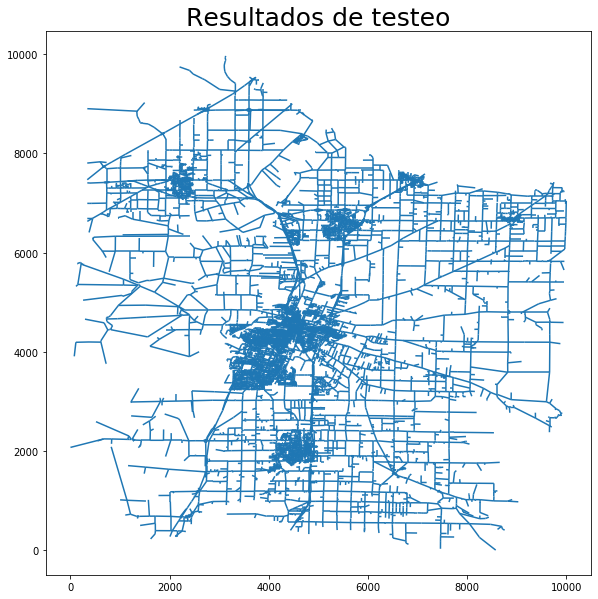

In [301]:
f, ax = plt.subplots(figsize=(10,10 ))
ax.set_title("Resultados de testeo", fontsize=25)
ax = df.plot(ax = ax, 
                   figsize=(10, 10),
                   legend = True)

plt.show()

In [295]:
def plot_random_graph(G, edges_location):
    # Armamos listas de extremos de vertices
    G_id1 = [edge[0] for edge in G.edges()]
    G_id2 = [edge[1] for edge in G.edges()]
    
    # Filtramos elementos que están contenidos
    filtered = edges_location.loc[(edges_location['ID_1'].isin(G_id1)) & (edges_location['ID_2'].isin(G_id2))]
    
    # Graficamos
    df = gpd.GeoDataFrame(filtered['geometry'])
    f, ax = plt.subplots(figsize=(15, 15))
    ax.set_title("Visualizacion grafo aleatorio", fontsize=25)
    ax = df.plot(ax = ax, 
                       figsize=(10, 10),
                       legend = True)
    plt.show()        
    

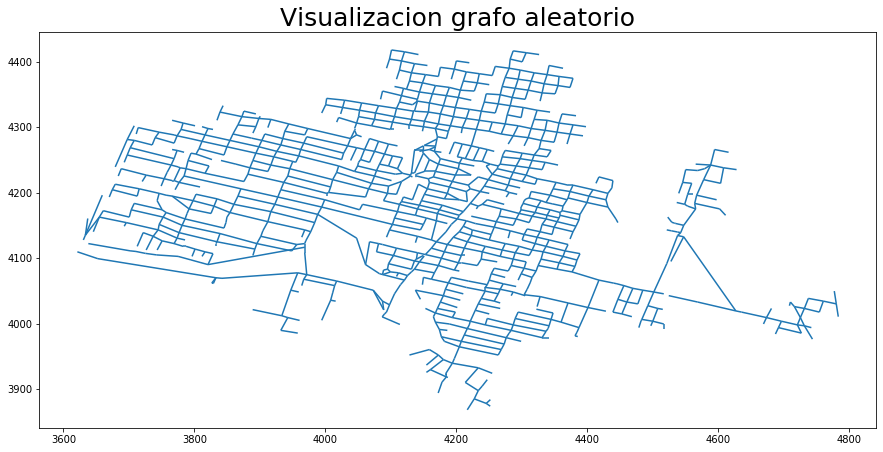

In [302]:
G_ = generate_random_graph(G, 1000, nodes_location, 0.2, 4)
plot_random_graph(G_, edges_location)

In [303]:
len(G_.nodes()), len(G_.edges())

(1001, 1164)